In [2]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt

In [3]:
def sorting(centers_initial, centers_present):
    '''this function sorts the centers detected.
    '''
    centers_intermediate = np.ones((5, 2))
    # looping
    for i in range(5):
        for j in range(5):
            # calculating distance and judge
            if np.sqrt(np.sum(np.square(centers_initial[i]-centers_present[j]))) < 40:
                centers_intermediate[i] = centers_present[j]
                break
    centers_intermediate = centers_intermediate.astype(np.int16)
    return centers_intermediate


def angle_between_lines(p1, p2, p3):
    """
    Calculate the angle between the line p1-p2 and p2-p3
    """
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])

    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(cosine_angle)

    return angle * 180 / math.pi

In [4]:
file_path = 'soft-robotics-demo-slow.mp4'
vc = cv.VideoCapture(file_path)

if (vc.isOpened() == False):
    print("Error opening video stream or file")

origin = np.array([500, 0])
# dims 1920x1080
shape = np.array([1200, 1080])

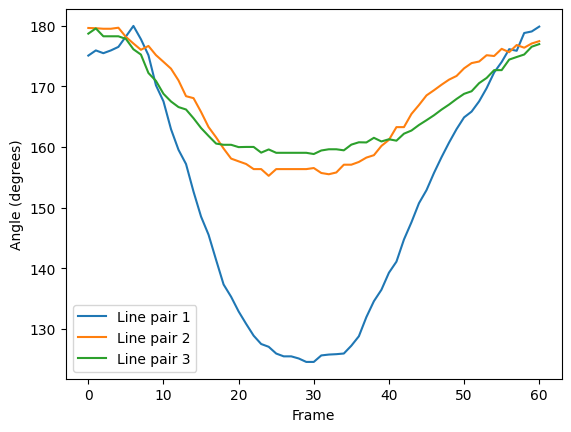

In [5]:
centers_temp = np.array([])
angles_list = []

while (vc.isOpened()):
    ret, img_rgb = vc.read()

    # cropping
    img_rgb = img_rgb[origin[1]:shape[1], origin[0]:shape[0]]

    # blurring
    img_rgb = cv.medianBlur(img_rgb, 5)

    img_hsv = cv.cvtColor(img_rgb, cv.COLOR_BGR2HSV)

    # detecting points by color
    red_hsv_lower = np.array([0, 50, 50])
    red_hsv_higher = np.array([10, 255, 255])
    mask1 = cv.inRange(img_hsv, lowerb=red_hsv_lower,
                        upperb=red_hsv_higher)

    red_hsv_lower = np.array([156, 50, 50])
    red_hsv_higher = np.array([180, 255, 255])
    mask2 = cv.inRange(img_hsv, lowerb=red_hsv_lower,
                        upperb=red_hsv_higher)
    mask = mask1 + mask2

    # detecting contours
    contours, hierarchy = cv.findContours(
        mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    # finding centers of contours
    centers = []
    for cnt in contours:
        (x, y), radius = cv.minEnclosingCircle(cnt)
        center = (int(x), int(y))

        cv.circle(img_rgb, center, 5, (255, 0, 0), -1)
        centers.append([center[0], center[1]])

    centers = np.array(centers)
    if len(centers_temp) == 0:
        centers_temp = centers

    # sorting
    centers = sorting(centers_temp, centers)
    centers_temp = centers

    # calculating angles
    angles = []
    for i in range(len(centers)-2):
        angles.append(angle_between_lines(
            centers[i], centers[i+1], centers[i+2]))
    angles_list.append(angles)

    # drawing lines
    for i in range(len(centers)-1):
        cv.line(img_rgb, (centers[i, 0], centers[i, 1]),
                (centers[i+1, 0], centers[i+1, 1]), (255, 0, 0), 2)

    if ret:
        cv.imshow('image', img_rgb)

        if cv.waitKey(27) & 0xFF == ord('q'):
            break

    else:
        break

cv.destroyAllWindows()

# After the video processing loop
angles_array = np.array(angles_list)

# Plot the angles for each adjacent line pair
for i in range(angles_array.shape[1]):
    plt.plot(angles_array[:, i], label=f"Line pair {i+1}")

plt.xlabel("Frame")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()
